In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score

In [3]:
from sklearn.datasets import make_blobs

In [4]:
from umap import UMAP

In [5]:
plt.style.use('dark_background')

# Clustering

## Toy example to illustrate concepts

In [6]:
npts = 1000
nc = 6
X, y = make_blobs(n_samples=npts, centers=nc)

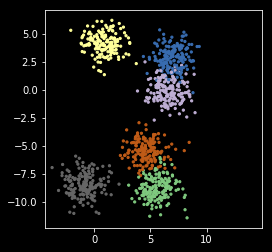

In [7]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=y,
            cmap=plt.cm.get_cmap('Accent', nc))
plt.axis('square')
pass

## How to cluster

1. Choose a clustering algorithm
2. Choose the number of clusters

### K-means

There are many different clustering methods, but K-means is fast, scales well, and can be interpreted as a probabilistic model. We will write 3 versions of the K-means algorithm to illustrate the main concepts. The algorithm is very simple:

1. Start with $k$ centers with labels $0, 1, \ldots, k-1$
2. Find the distance of each data point to each center
3. Assign the data points nearest to a center to its label
4. Use the mean of the points assigned to a center as the new center
5. Repeat for a fixed number of iterations or until the centers stop changing

Note: If you want a probabilistic interpretation, just treat the final solution as a mixture of (multivariate) normal distributions. K-means is often used to initialize the fitting of full statistical mixture models, which are computationally more demanding and hence slower. 

#### Distance between sets of vectors

In [8]:
from scipy.spatial.distance import cdist

In [9]:
pts = np.arange(6).reshape(-1,2)
pts

array([[0, 1],
       [2, 3],
       [4, 5]])

In [10]:
mus = np.arange(4).reshape(-1, 2)
mus

array([[0, 1],
       [2, 3]])

In [11]:
cdist(pts, mus)

array([[0.        , 2.82842712],
       [2.82842712, 0.        ],
       [5.65685425, 2.82842712]])

#### Version 1

In [12]:
def my_kemans_1(X, k, iters=10):
    """K-means with fixed number of iterations."""
    
    r, c = X.shape
    centers = X[np.random.choice(r, k, replace=False)]
    for i in range(iters):
        m = cdist(X, centers)
        z = np.argmin(m, axis=1)
        centers = np.array([np.mean(X[z==i], axis=0) for i in range(k)])
    return (z, centers)

In [13]:
np.random.seed(2018)
z, centers = my_kemans_1(X, nc)

#### Note that K-means can get stuck in local optimum

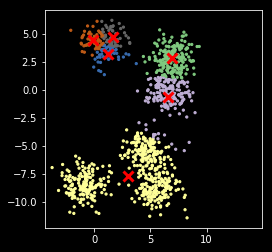

In [14]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=z,
            cmap=plt.cm.get_cmap('Accent', nc))
plt.scatter(centers[:, 0], centers[:, 1], marker='x', 
            linewidth=3, s=100, c='red')
plt.axis('square')
pass

#### Version 2

In [15]:
def my_kemans_2(X, k, tol= 1e-6):
    """K-means with tolerance."""
    
    r, c = X.shape
    centers = X[np.random.choice(r, k, replace=False)]
    delta = np.infty
    while delta > tol:
        m = cdist(X, centers)
        z = np.argmin(m, axis=1)
        new_centers = np.array([np.mean(X[z==i], axis=0) for i in range(k)])
        delta = np.sum((new_centers - centers)**2)
        centers = new_centers
    return (z, centers)

In [16]:
np.random.seed(2018)
z, centers = my_kemans_2(X, nc)

#### Still stuck in local optimum

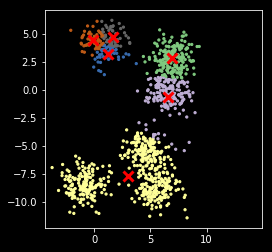

In [17]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=z,
            cmap=plt.cm.get_cmap('Accent', nc))
plt.scatter(centers[:, 0], centers[:, 1], marker='x', 
            linewidth=3, s=100, c='red')
plt.axis('square')
pass

#### Version 3

Use of a score to evaluate the goodness of fit. In this case, the simplest score is just the sum of distances from each point to its nearest center.

In [18]:
def my_kemans_3(X, k, tol=1e-6, n_starts=10):
    """K-means with tolerance and random restarts."""
    
    r, c = X.shape
    best_score = np.infty
  
    for i in range(n_starts):
        centers = X[np.random.choice(r, k, replace=False)]
        delta = np.infty
        while delta > tol:
            m = cdist(X, centers)
            z = np.argmin(m, axis=1)
            new_centers = np.array([np.mean(X[z==i], axis=0) for i in range(k)])
            delta = np.sum((new_centers - centers)**2)
            centers = new_centers
        score = m[z].sum()
        if score < best_score:
            best_score = score
            best_z = z
            best_centers = centers
    return (best_z, best_centers)

In [19]:
np.random.seed(2018)
z, centers = my_kemans_3(X, nc)

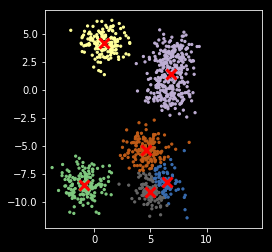

In [20]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=z,
            cmap=plt.cm.get_cmap('Accent', nc))
plt.scatter(centers[:, 0], centers[:, 1], marker='x', 
            linewidth=3, s=100, c='red')
plt.axis('square')
pass

## Model selection

We use AMIS for model selection. You can also use likelihood-based methods by interpreting the solution as a mixture of normals but we don't cover those approaches here. There are also other ad-hoc methods - see `sckikt-lean` [docs](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation) if you are interested. 

### Mutual Information Score (MIS)

The mutual information is defined as

$$
I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log \left( \frac{p(x, y)}{p(x)p(y)} \right)
$$

It measures how much knowing $X$ reduces the uncertainty about $Y$ (and vice versa). 

- If $X$ is independent of $Y$, then $I(X; Y) = 0$
- If $X$ is a deterministic function of $Y$, then $I(X; Y) = 1$

It is equivalent to the Kullback-Leibler divergence

$$
\text{KL}(p(x,y) \mid\mid p(x)p(y)
$$

We use AMIS (Adjusted MIS) here, which adjusts for the number of clusters used in the clustering method.

From the documentation

```
AMI(U, V) = [MI(U, V) - E(MI(U, V))] / [max(H(U), H(V)) - E(MI(U, V))]
```

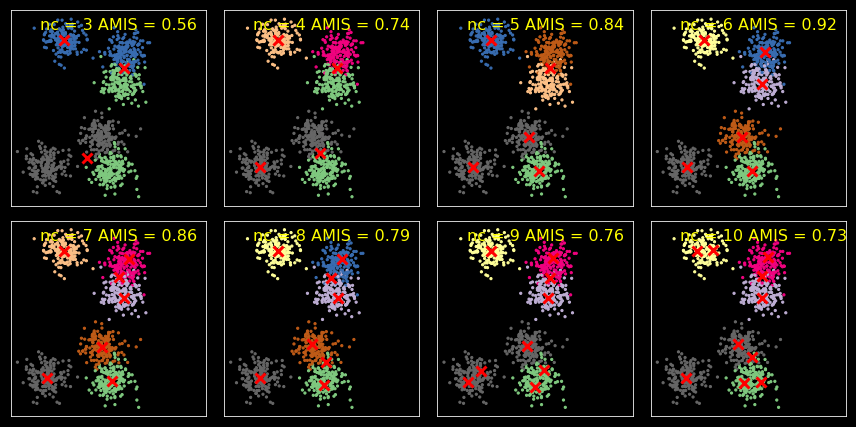

In [21]:
ncols = 4
nrows = 2
plt.figure(figsize=(ncols*3, nrows*3))
for i, nc in enumerate(range(3, 11)):
    kmeans = KMeans(nc, n_init=10)
    clusters = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    amis = adjusted_mutual_info_score(y, clusters)
    plt.subplot(nrows, ncols, i+1)
    plt.scatter(X[:, 0], X[:, 1], s=5, c=y,
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.scatter(centers[:, 0], centers[:, 1], marker='x', 
                linewidth=3, s=100, c='red')
    plt.text(0.15, 0.9, 'nc = %d AMIS = %.2f' % (nc, amis), 
             fontsize=16, color='yellow',
             transform=plt.gca().transAxes)
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()

## Comparing across samples

In [22]:
X1 = X + np.random.normal(0, 1, X.shape)

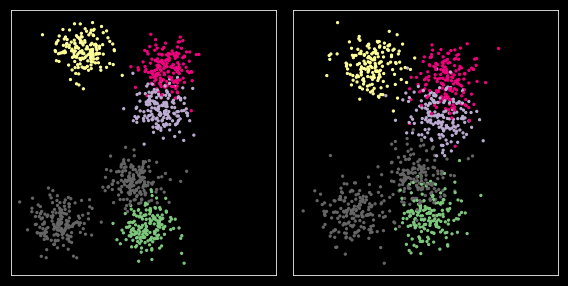

In [23]:
plt.figure(figsize=(8, 4))
for i, xs in enumerate([X, X1]):
    plt.subplot(1,2,i+1)
    plt.scatter(xs[:, 0], xs[:, 1], s=5, c=y,
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()
pass

### Option 1: Using reference sample

In [24]:
nc = 6
kmeans = KMeans(nc, n_init=10)
kmeans.fit(X)
z1 = kmeans.predict(X)
z2 = kmeans.predict(X1)
zs = [z1, z2]

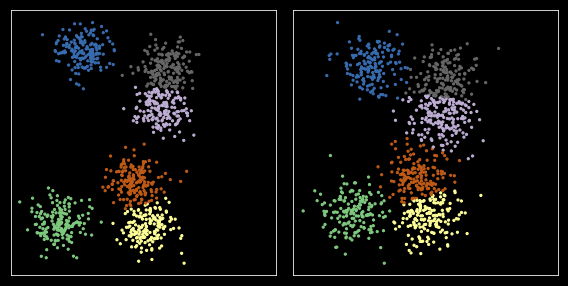

In [25]:
plt.figure(figsize=(8, 4))
for i, xs in enumerate([X, X1]):
    plt.subplot(1,2,i+1)
    plt.scatter(xs[:, 0], xs[:, 1], s=5, c=zs[i],
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()
pass

### Option 2: Pooling

In [26]:
Y = np.r_[X, X1]
kmeans = KMeans(nc, n_init=10)
kmeans.fit(Y)
zs = np.split(kmeans.predict(Y), 2)

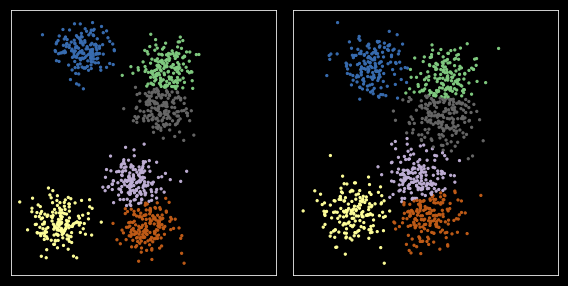

In [27]:
plt.figure(figsize=(8, 4))
for i, xs in enumerate([X, X1]):
    plt.subplot(1,2,i+1)
    plt.scatter(xs[:, 0], xs[:, 1], s=5, c=zs[i],
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()
pass

### Option 3: Matching

In [28]:
from scipy.optimize import linear_sum_assignment

In [29]:
np.random.seed(2018)
kmeans = KMeans(nc, n_init=10)
c1 = kmeans.fit(X).cluster_centers_
z1 = kmeans.predict(X)
c2 = kmeans.fit(X1).cluster_centers_
z2 = kmeans.predict(X1)
zs = [z1, z2]
cs = [c1, c2]

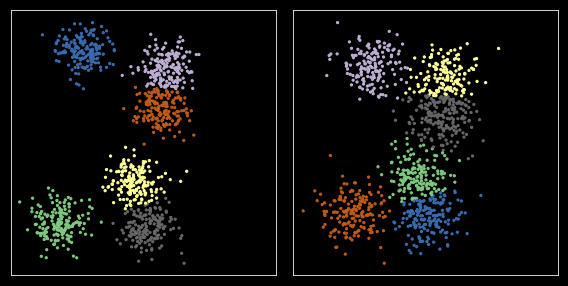

In [30]:
plt.figure(figsize=(8, 4))
for i, xs in enumerate([X, X1]):
    plt.subplot(1,2,i+1)
    z = zs[i]
    c = cs[i]

    plt.scatter(xs[:, 0], xs[:, 1], s=5, c=z,
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()
pass

#### Define cost function

We use a simple cost as just the distance between centers. More complex dissimilarity measures could be used.

In [31]:
cost = cdist(c1, c2)

#### Run the Hungarian (Muunkres) algorithm for bipartitie matching

In [32]:
row_ind, col_ind = linear_sum_assignment(cost)

In [33]:
row_ind, col_ind

(array([0, 1, 2, 3, 4, 5]), array([4, 2, 0, 1, 5, 3]))

#### Swap cluster indexes to align data sets

In [34]:
z1_aligned = col_ind[z1]
zs = [z1_aligned, z2]

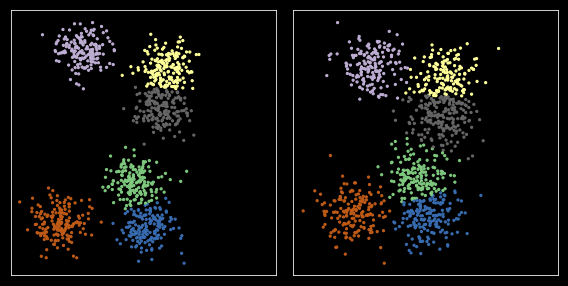

In [35]:
plt.figure(figsize=(8, 4))
for i, xs in enumerate([X, X1]):
    plt.subplot(1,2,i+1)
    plt.scatter(xs[:, 0], xs[:, 1], s=5, c=zs[i],
                cmap=plt.cm.get_cmap('Accent', nc))
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')
plt.tight_layout()
pass